# Test data

In [1]:
from theano.sandbox import cuda
cuda.use('gpu0')

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1080 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29



In [2]:
%matplotlib inline
from __future__ import print_function, division

import utils; reload(utils)
from utils import *
from IPython.display import FileLink

Using Theano backend.


In [3]:
batch_size=64
p=0.8
path = 'data/botles/'
classes=['vino', 'vodka', 'cogniak', 'shampan']

## Create batches

In [4]:
test_batches = get_batches(path+'test', batch_size=batch_size, shuffle=False)

Found 57 images belonging to 1 classes.


In [5]:
(val_classes, trn_classes, val_labels, trn_labels, val_filenames, filenames, test_filenames) = get_classes(path)

Found 2688 images belonging to 4 classes.
Found 672 images belonging to 4 classes.
Found 57 images belonging to 1 classes.


In [6]:
vgg = Vgg16()
model=vgg.model
last_conv_idx = [i for i,l in enumerate(model.layers) if type(l) is Convolution2D][-1]
conv_layers = model.layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

In [7]:
def get_bn_da_layers(p):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(4, activation='softmax')
        ]

# Submit

In [8]:
bn_model = Sequential(get_bn_da_layers(p))
bn_model.load_weights(path+'results/da_conv8_1_3.h5')

We'll find a good clipping amount using the validation set, prior to submitting.

Receivig full model where productivity would be same:

In [9]:
final_model = Sequential(conv_layers)
bn_layers = bn_model.layers #get_bn_da_layers(p)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: 
    final_model.add(layer)
    

[[ 0.0281  0.4551  0.5125  0.0042]]
Class is cogniak


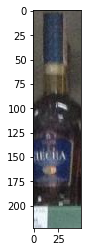

In [10]:
from skimage.io import imread
import cv2

original=imread(path+'test/100/3.jpg')#sham1#cog#vodka

s = cv2.resize(original, (224, 224))
s=s.transpose(2, 0, 1)
a=s.reshape((1, s.shape[0], s.shape[1], s.shape[2]))

prediction = final_model.predict(a)

print (prediction)
print("Class is {}".format(classes[np.argmax(prediction, axis=1)[0]]))
plt.imshow(original, interpolation='none')

In [11]:
def do_clip(arr, mx): return np.clip(arr, (1-mx)/9, mx)

conv_test_feat = conv_model.predict_generator(test_batches, test_batches.nb_sample)
preds = bn_model.predict(conv_test_feat, batch_size=batch_size*2)
subm = do_clip(preds,0.93)

submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])
submission

,img,vino,vodka,cogniak,shampan
0,0.jpg,0.930000,0.010243,0.007778,0.007778
1,0jpg.jpg,0.930000,0.007778,0.007778,0.007778
2,1.jpg,0.007778,0.930000,0.007778,0.007778
3,10.jpg,0.007778,0.007778,0.007778,0.930000
4,11.jpg,0.930000,0.007778,0.007778,0.007778
5,12.jpg,0.930000,0.007778,0.009513,0.007778
6,13.jpg,0.030927,0.032437,0.930000,0.007778
7,14.jpg,0.015829,0.930000,0.007778,0.007778
8,15.jpg,0.084884,0.911997,0.007778,0.007778
9,16.jpg,0.544594,0.007778,0.444635,0.007778


In [12]:
test_feat2 = final_model.predict_generator(test_batches, test_batches.nb_sample)

submission = pd.DataFrame(test_feat2, columns=classes)
submission.insert(0, 'img', [a[4:] for a in test_filenames])
submission

,img,vino,vodka,cogniak,shampan
0,0.jpg,9.853528e-01,1.024282e-02,3.676127e-03,0.000728
1,0jpg.jpg,9.945642e-01,5.260949e-03,1.138534e-04,0.000061
2,1.jpg,2.414734e-03,9.971483e-01,3.633014e-04,0.000074
3,10.jpg,1.313909e-07,1.659242e-07,3.032656e-05,0.999969
4,11.jpg,9.934476e-01,5.856066e-03,3.648461e-04,0.000331
5,12.jpg,9.843313e-01,3.655447e-03,9.513199e-03,0.002500
6,13.jpg,3.092680e-02,3.243688e-02,9.364485e-01,0.000188
7,14.jpg,1.582911e-02,9.824538e-01,1.282998e-03,0.000434
8,15.jpg,8.488408e-02,9.119970e-01,1.615143e-03,0.001504
9,16.jpg,5.445942e-01,3.009790e-03,4.446346e-01,0.007761
